In [2]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

#metrics
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc


%matplotlib inline

In [71]:
df_math = pd.read_csv('student-mat.csv')
df_port = pd.read_csv('student-por.csv')


In [72]:
cat_data = pd.get_dummies(df_port[['school', 'sex','address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']],drop_first=True)
nominal_cat = pd.get_dummies(df_port[['Mjob','Fjob','reason','guardian']],drop_first=True)
numeric_data = df_port[['age','Medu','Fedu','traveltime','studytime','famrel','freetime','goout','Dalc','Walc','health','absences','failures']]

In [73]:
grades = pd.DataFrame()
#pass = 1, fail = 0
def passfail(grade):
    if grade >=10:
        return 0
    if grade <10:
        return 1
grades['G1'] = df_port['G1'].apply(passfail)
grades['G2'] = df_port['G2'].apply(passfail)
grades['G3'] = df_port['G3'].apply(passfail)

In [74]:
df = pd.concat([grades, cat_data,numeric_data, nominal_cat], axis = 1)

In [77]:
# Recursive Feature Elimination

from sklearn.feature_selection import RFE
X = df.drop(['G1','G2','G3'], axis = 1)
y = df['G1']

model = LogisticRegression()
# create the RFE model and select 20 attributes
rfe = RFE(model, 10)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
selected_features_ranking = list(zip(X.columns,rfe.support_,rfe.ranking_))
selected_features_ranking

[('school_MS', True, 1),
 ('sex_M', True, 1),
 ('address_U', False, 29),
 ('famsize_LE3', False, 3),
 ('Pstatus_T', False, 16),
 ('schoolsup_yes', True, 1),
 ('famsup_yes', False, 17),
 ('paid_yes', False, 8),
 ('activities_yes', False, 5),
 ('nursery_yes', False, 24),
 ('higher_yes', True, 1),
 ('internet_yes', False, 14),
 ('romantic_yes', False, 13),
 ('age', False, 28),
 ('Medu', False, 26),
 ('Fedu', False, 21),
 ('traveltime', False, 23),
 ('studytime', True, 1),
 ('famrel', False, 25),
 ('freetime', False, 11),
 ('goout', False, 12),
 ('Dalc', False, 9),
 ('Walc', False, 27),
 ('health', False, 20),
 ('absences', False, 19),
 ('failures', True, 1),
 ('Mjob_health', False, 18),
 ('Mjob_other', False, 22),
 ('Mjob_services', True, 1),
 ('Mjob_teacher', False, 7),
 ('Fjob_health', False, 6),
 ('Fjob_other', False, 30),
 ('Fjob_services', False, 10),
 ('Fjob_teacher', True, 1),
 ('reason_home', False, 2),
 ('reason_other', False, 4),
 ('reason_reputation', False, 15),
 ('guardian_mo

In [78]:
#create a new dataframe with only features selected by RFE
selected_features = [i[0] for i in selected_features_ranking if i[1] == True]
selected_features_df = pd.DataFrame()
for i in selected_features:
    selected_features_df[i] = df[i]
    
selected_features_df.columns

Index(['school_MS', 'sex_M', 'schoolsup_yes', 'higher_yes', 'studytime',
       'failures', 'Mjob_services', 'Fjob_teacher', 'guardian_mother',
       'guardian_other'],
      dtype='object')

In [47]:
df = pd.merge(df[['G1','G2', 'G3']].reset_index(), selected_features_df.reset_index(), on = 'index', how='inner').set_index('index')
df.dropna(inplace=True)

## Train/Test Split

In [48]:
X = df.drop(['G1'], axis = 1)
y = df['G1']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### with normalization

In [50]:
normalizer = preprocessing.Normalizer()
X_norm = normalizer.fit_transform(X)

In [51]:
X_train_norm, X_test_norm, y_train, y_test = train_test_split(X_norm, y, test_size=0.33, random_state=42)

## Models Comparison

In [52]:
models = [LogisticRegression(),
          GaussianNB(),
          DecisionTreeClassifier(),
          RandomForestClassifier(),
          GradientBoostingClassifier()]

models_norm = [KNeighborsClassifier(), 
          SVC(probability=True)]

model_names = ['Logistic', 'Naive Bayes','Decision Tree', 'Random Forest','Gradient Boosting','KNN', 'SVM']

In [64]:
accuracy = []
precision_pass = []
precision_fail = []
recall_pass = []
recall_fail = []
f1_pass = []
f1_fail = []
auc = []

## Go through the models and find the scores
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    accuracy.append( accuracy_score(y_test, y_pred) )
    precision_pass.append( precision_score(y_test, y_pred, pos_label=0) )
    precision_fail.append( precision_score(y_test, y_pred, pos_label=1) )
    recall_pass.append( recall_score(y_test, y_pred, pos_label=0))
    recall_fail.append( recall_score(y_test, y_pred, pos_label=1))
    f1_pass.append( f1_score(y_test, y_pred, pos_label=0) )
    f1_fail.append( f1_score(y_test, y_pred, pos_label=1) )
    auc.append(roc_auc_score(y_test, y_pred_prob))
    
for model in models_norm:
    model.fit(X_train_norm, y_train)
    y_pred = model.predict(X_test_norm)
    
    accuracy.append( accuracy_score(y_test, y_pred) )
    precision_pass.append( precision_score(y_test, y_pred, pos_label=0) )
    precision_fail.append( precision_score(y_test, y_pred, pos_label=1) )
    recall_pass.append( recall_score(y_test, y_pred, pos_label=0))
    recall_fail.append( recall_score(y_test, y_pred, pos_label=1))
    f1_pass.append( f1_score(y_test, y_pred, pos_label=0) )
    f1_fail.append( f1_score(y_test, y_pred, pos_label=1) )
    auc.append(roc_auc_score(y_test, y_pred_prob))

accuracy_df = pd.DataFrame({'accuracy':accuracy, 'precision-pass':precision_pass, 'precision-fail':precision_fail,
                            'recall-pass':recall_pass, 'recall-fail':recall_fail, 'f1-pass':f1_pass, 'f1-fail':f1_fail, 'auc': auc})
accuracy_df.set_index([model_names])

,accuracy,auc,f1-fail,f1-pass,precision-fail,precision-pass,recall-fail,recall-pass
Logistic,0.879070,0.909516,0.697674,0.924419,0.810811,0.893258,0.612245,0.957831
Naive Bayes,0.883721,0.924760,0.731183,0.925816,0.772727,0.912281,0.693878,0.939759
Decision Tree,0.851163,0.779936,0.652174,0.905325,0.697674,0.889535,0.612245,0.921687
Random Forest,0.841860,0.871588,0.613636,0.900585,0.692308,0.875000,0.551020,0.927711
Gradient Boosting,0.837209,0.894517,0.606742,0.897361,0.675000,0.874286,0.551020,0.921687
KNN,0.860465,0.894517,0.687500,0.910180,0.702128,0.904762,0.673469,0.915663
SVM,0.888372,0.894517,0.714286,0.930636,0.857143,0.894444,0.612245,0.969880


### ROC Curve

In [65]:
## Calc and store each ROC and AUC
fpr_list = []
tpr_list = []
auc_list = []
for model in models:
    y_pred_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(metrics.auc(fpr, tpr))
    
for model in models_norm:
    y_pred_prob = model.predict_proba(X_test_norm)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(metrics.auc(fpr, tpr))

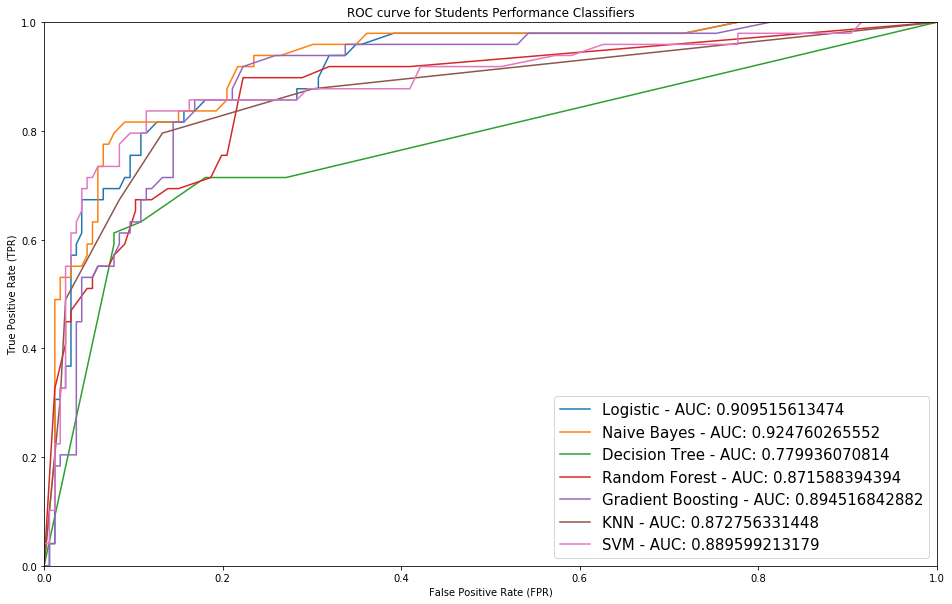

In [66]:
## Plot them all on 1 graph
plt.figure(figsize=(16,10))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC curve for Students Performance Classifiers')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], label = model_names[i] + ' - AUC: ' + str(auc_list[i]))
plt.legend(loc = 0, fontsize = 15)